# Import Libraries <a id='import'></a>

In [1]:
import os
home = os.path.expanduser("~")
from glob import glob
import numpy as np
from astropy.io import fits

In [2]:
# Define CRDS paths *before* importing jwst pipeline
# otherwise you'll get FileNotFoundError: [Errno 2] : No such file or directory: '$HOME/crds_cache/config/jwst/server_config'

#os.environ["CRDS_PATH"] = "$HOME/crds_cache"
#os.environ["CRDS_PATH"] = '/grp/crds/cache/' at STScI
os.environ["CRDS_PATH"] = os.path.join(home, "crds_cache")
os.makedirs(os.environ['CRDS_PATH'], exist_ok=True)
print(os.environ['CRDS_PATH'])

os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

import crds

/Users/dcoe/crds_cache


In [3]:
# Import JWST pipeline 

import jwst
from jwst import datamodels
from jwst.pipeline import Detector1Pipeline   # calwebb_detector1
from jwst.pipeline import Spec2Pipeline       # calwebb_spec2
from jwst.pipeline import Spec3Pipeline       # calwebb_spec3
from jwst.extract_1d import Extract1dStep     # Extract1D Individual Step
from jwst.associations import asn_from_list   # create association file
import json

print("JWST Calibration Pipeline Version = {}".format(jwst.__version__)) 
# Note if you're using a development version, it might not report the correct version number here

JWST Calibration Pipeline Version = 1.13.4


In [4]:
try:
    print("Current Operational CRDS Context = {}".format(crds.get_default_context()))
except:
    print('CRDS server not found (are you offline?)')

Current Operational CRDS Context = jwst_1225.pmap


In [5]:
# To run faster on multiple cores in parallel
import multiprocessing as mp 
print("Number of processors: ", mp.cpu_count())

Number of processors:  10


In [6]:
# To retrieve data from MAST
import astroquery
print('astroquery version', astroquery.__version__)
from astroquery.mast import Observations, Mast

from astropy.table import Table, vstack, unique

astroquery version 0.4.6


In [7]:
# To plot and view results

import matplotlib # as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})  # 18

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe # https://stackoverflow.com/questions/25426599/matplotlib-how-to-buffer-label-text

from astropy.visualization import simple_norm, ImageNormalize, AsinhStretch, ManualInterval, LogStretch, LinearStretch
from astropy.stats import sigma_clip, sigma_clipped_stats  # , SigmaClip

In [8]:
# Color image

import PIL
from PIL import Image, ImageEnhance
PIL.Image.MAX_IMAGE_PIXELS = 933120000  # allow it to load large image

In [9]:
import astropy
#import astropy.io.fits as pyfits
from astropy.io import fits
import astropy.wcs as wcs
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, vstack, unique

# Helper Functions <a id='helper'></a>

In [10]:
# Helper function to download JWST files from MAST
def download_jwst_files(filenames, download_dir, mast_dir='mast:jwst/product'):
    # Download data
    #manifest = Observations.download_products(chosen_obsIDs, download_dir=DOWNLOAD_DIR)  # , flat=True

    downloaded_files = []
    os.makedirs(download_dir, exist_ok=True)
    for filename in filenames:
        filename   = os.path.basename(filename)
        mast_path  = os.path.join(mast_dir,     filename)
        local_path = os.path.join(download_dir, filename)
        if os.path.exists(local_path):
            print(local_path, 'EXISTS')
        else:
            # Can let this command check if local file exists
            # However, it will delete it if it's there and the wrong size (e.g., reprocessed)
            Observations.download_file(mast_path,   local_path=local_path)
        downloaded_files.append(local_path)

    return downloaded_files

In [11]:
from IPython.display import JSON  # nicer interactive output of JSON dictionaries

def print_dict(d, indent=0): # another way to view dictionary contents
    for key in d.keys():
        val = d[key]
        try:
            keys = val.keys()
            print(' ' * indent, key)
            print_dict(val, indent+4)
        except:
            if type(val) == type([]):
                for i, item in enumerate(val):
                    print(' ' * indent, '[%d]' % i)
                    print_dict(item, indent+4)
            else:
                print(' ' * indent, key, ':', d[key])

In [12]:
def between(lo, x, hi):
    return (lo <= x) * (x <= hi)

In [13]:
def roundint(x):
    return int(np.round(x))

def slices_extent(x, y, dx, dy=0):
    dy = dy or dx
    xlo = roundint(x-dx)
    xhi = roundint(x+dx+1)
    ylo = roundint(y-dy)
    yhi = roundint(y+dy+1)
    xslice = slice(xlo, xhi)
    yslice = slice(ylo, yhi)
    slices = yslice, xslice
    extent = xlo, xhi, ylo, yhi
    return slices, extent

In [14]:
# Helper functions to select subset of files from list
def allin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element not in list_or_string:
            return False
    return True

def anyin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element in list_or_string:
            return True
    return False

# Select subset of files containing all search strings
def select_files(all_files, search_strings=[]):
    chosen_files = [file for file in all_files if allin(search_strings, file)]
    if len(chosen_files) == 1:
        chosen_files = chosen_files[0]
    return chosen_files    

# Select source

In [15]:
source_id = 6355

# Wavelength grid

### S2D model WCS transform –> RA, Dec, wavelength

https://jwst-pipeline.readthedocs.io/en/latest/_modules/jwst/assign_wcs/nirspec.html

In [16]:
spec3_output_dir = 'spec3'

s2d_files = glob(os.path.join(spec3_output_dir, '*_s2d.fits'))
s2d_file  = select_files(s2d_files, ['s%05d' % source_id])
s2d_file

'spec3/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits'

In [17]:
s2d_model = datamodels.open(s2d_file)
#s2d_model.info(max_rows=99999)  # show all contents
#s2d_data = s2d_model.data + 0

In [18]:
if 'slits' in list(s2d_model):  # s2d has all the objects; extract the one with source_id
    source_ids = [slit.source_id for slit in s2d_model.slits]
    i_slit = source_ids.index(source_id)
    slit_model = s2d_model.slits[i_slit]
else:  # s2d only has one object
    slit_model = s2d_model
    i_slit = 0

s2d_data = slit_model.data + 0  # load and make copy
s2d_data = np.where(slit_model.err, s2d_data, np.nan)  # Replace zeros with nan where there is no data

In [19]:
slit_wcs = s2d_model.meta.wcs
y, x = np.mgrid[:s2d_data.shape[0], :s2d_data.shape[1]] # grid of pixel x,y indices 
det2sky = slit_wcs.get_transform('detector', 'world') # coordinate transform from detector pixels to sky 
ra, dec, s2d_waves = det2sky(x, y) # RA, Dec, wavelength (microns) for each pixel 
s2d_wave = s2d_waves[0, :] # only need a single row of values since this is the rectified spectrum 

In [20]:
s2d_wave

array([2.84863722, 2.85043148, 2.85222575, ..., 5.28289045, 5.28467829,
       5.28646621])

### can also read wavelength grid from x1d file

In [21]:
# Load 1D extraction
x1d_file = s2d_file.replace('s2d', 'x1d')
print(x1d_file)
x1d_model = datamodels.open(x1d_file)
#x1d_model.info(max_rows=99999)  # show all contents

spec3/jw02736-o007_s06355_nirspec_f290lp-g395m_x1d.fits


In [22]:
x1d_wave = x1d_model.spec[i_slit].spec_table.WAVELENGTH

In [23]:
x1d_wave

array([2.84863722, 2.85043148, 2.85222575, ..., 5.28289045, 5.28467829,
       5.28646621])

### They're identical

In [24]:
s2d_wave - x1d_wave

array([-4.4408921e-16, -4.4408921e-16,  4.4408921e-16, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00])

In [25]:
np.max(np.abs(s2d_wave - x1d_wave))

8.881784197001252e-16

# Metafile

In [26]:
msa_metafile = fits.getval(s2d_file, 'MSAMETFL')
msa_metafile

'jw02736007001_01_msa.fits'

In [27]:
msa_metafile = download_jwst_files([msa_metafile], './')[0]

./jw02736007001_01_msa.fits EXISTS


In [28]:
msa_hdu_list = fits.open(msa_metafile)
msa_hdu_list.info()

Filename: ./jw02736007001_01_msa.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  SHUTTER_IMAGE    1 ImageHDU         8   (342, 730)   int16   
  2  SHUTTER_INFO    1 BinTableHDU     33   1318R x 12C   [I, I, I, I, I, J, 1A, 6A, E, E, I, 1A]   
  3  SOURCE_INFO    1 BinTableHDU     25   119R x 8C   [J, J, 20A, 31A, D, D, 30A, D]   


In [29]:
msa_hdu_list['SHUTTER_IMAGE'].data.shape

(730, 342)

In [30]:
shutter_table = Table(msa_hdu_list['SHUTTER_INFO'].data)
#shutter_table

In [31]:
set(shutter_table['msa_metadata_id'])  # Two MSA configs

{1, 76}

In [32]:
source_ids = set(shutter_table['source_id'])
source_ids = np.sort(list(source_ids))#.tolist()

In [33]:
source_table = Table(msa_hdu_list['SOURCE_INFO'].data)
select_source_table = source_table[source_table['source_id'] == source_id]
select_source_table

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,str20,str31,float64,float64,str30,float64
2736,6355,2736_6355,6355,110.84459416965377,-73.4350589621277,None,0.1


In [34]:
#source_ra, source_dec = 110.8446, -73.43506
source_ra  = select_source_table['ra'][0]
source_dec = select_source_table['dec'][0]
source_ra, source_dec

(110.84459416965377, -73.4350589621277)

In [35]:
shutter_table_dither1 = shutter_table[shutter_table['dither_point_index'] == 1]
shutter_table_dither1 = shutter_table_dither1[shutter_table_dither1['msa_metadata_id'] == 1]
source_select = [(id == source_id) for id in shutter_table_dither1['source_id']]
source_shutter_table = shutter_table_dither1[source_select]
source_shutter_table

slitlet_id,msa_metadata_id,shutter_quadrant,shutter_row,shutter_column,source_id,background,shutter_state,estimated_source_in_shutter_x,estimated_source_in_shutter_y,dither_point_index,primary_source
int16,int16,int16,int16,int16,int32,str1,str6,float32,float32,int16,str1
72,1,3,138,83,6355,Y,OPEN,nan,nan,1,N
72,1,3,138,84,6355,N,OPEN,0.46437824,0.86562544,1,Y
72,1,3,138,85,6355,Y,OPEN,nan,nan,1,N
72,1,3,138,86,6355,Y,OPEN,nan,nan,1,N
72,1,3,138,87,6355,Y,OPEN,nan,nan,1,N


In [36]:
i_primary = list(source_shutter_table['primary_source']).index('Y')
i_primary

1

# Color Image

Created with [Trilogy](https://github.com/dancoe/trilogy)
using [NIRCam images in the DAWN JWST Archive (DJA)](https://dawn-cph.github.io/dja/imaging/v7/)

In [37]:
color_image_file = '/Users/dcoe/SMACS0723/dja/v7/color/smacs0723_color_sw.png'
im = Image.open(color_image_file)
im = im.transpose(method=Image.FLIP_TOP_BOTTOM)
color_image = np.asarray(im)

In [38]:
fits_image_file = glob('/Users/dcoe/SMACS0723/dja/v7/images/20mas/*.fits')[0]
fits_image_file  # for RA, Dec -> x, y

'/Users/dcoe/SMACS0723/dja/v7/images/20mas/smacs0723-grizli-v7.0-f200w-clear_drc_sci.fits'

In [39]:
hdu = fits.open(fits_image_file)
idata = 0
image_wcs = wcs.WCS(hdu[idata].header, hdu)
image_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 110.83403 -73.45429 
CRPIX : 9182.5 13030.5 
CD1_1 CD1_2  : -5.5555555555555e-06 0.0 
CD2_1 CD2_2  : 0.0 5.5555555555555e-06 
NAXIS : 24000  24000

# Mapping Slits to the Sky

In [40]:
slit2sky = slit_wcs.get_transform('slit_frame', 'world')

In [41]:
x_corners = 0, 0, 1, 1 
y_corners = 0, 1, 1, 0

https://jira.stsci.edu/browse/JP-1341

In [42]:
x_scale, y_scale = 1.38, 1.16  # should read more precise values from MSA reference file?

In [43]:
x_corners = np.array(x_corners) - 0.5
y_corners = np.array(y_corners) - 0.5

x_corners *= x_scale
y_corners *= y_scale

In [44]:
slitlet_ra, slitlet_dec, zero = slit2sky(x_corners, y_corners, 0)

In [45]:
estimated_source_in_shutter_x = source_shutter_table['estimated_source_in_shutter_x'][i_primary]
estimated_source_in_shutter_y = source_shutter_table['estimated_source_in_shutter_y'][i_primary]
estimated_source_in_shutter_x, estimated_source_in_shutter_y

(0.46437824, 0.86562544)

In [46]:
estimated_source_in_shutter_x -= 0.5
estimated_source_in_shutter_y -= 0.5

estimated_source_in_shutter_x *= x_scale
estimated_source_in_shutter_y *= y_scale

In [47]:
estimated_source_ra, estimated_source_dec, zero = slit2sky(estimated_source_in_shutter_x, estimated_source_in_shutter_y, 0)

In [48]:
estimated_source_coordinates = SkyCoord(ra=estimated_source_ra*u.deg, dec=estimated_source_dec*u.deg)
estimated_source_x, estimated_source_y = image_wcs.world_to_pixel(estimated_source_coordinates)

In [49]:
estimated_source_x, estimated_source_y

(array(8639.75976359), array(16485.51167486))

In [50]:
dx_rows    = source_shutter_table['shutter_row']    - source_shutter_table['shutter_row'][i_primary]
dy_columns = source_shutter_table['shutter_column'] - source_shutter_table['shutter_column'][i_primary]

In [51]:
dx_rows    = np.array(dx_rows)    * x_scale
dy_columns = np.array(dy_columns) * y_scale

In [52]:
xx = []
yy = []

for i in range(len(dx_rows)):
    slitlet_ra, slitlet_dec, zero = slit2sky(x_corners + dx_rows[i], y_corners + dy_columns[i], 0)
    slit_coordinates = SkyCoord(ra=slitlet_ra*u.deg, dec=slitlet_dec*u.deg)
    xy = x, y = image_wcs.world_to_pixel(slit_coordinates)
    xx.append(x)
    yy.append(y)
    
dx = 75  # pixels 0.02" -> dx = 1" so image stamp will be 2" on each side
slices, extent = slices_extent(np.mean(xx), np.mean(yy), dx)
xlo, xhi, ylo, yhi = extent
np.mean(xx), np.mean(yy)

(8626.18595467079, 16475.09497540909)

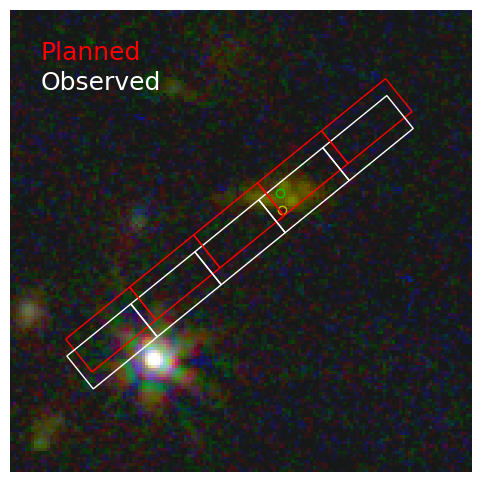

In [53]:
fig = plt.figure(figsize=(9.5, 6))
ax = fig.add_subplot(1, 1, 1) #, projection=imwcs) # , sharex=True, sharey=True)
ax.imshow(color_image[slices], extent=extent, origin='lower')

source_coordinates = SkyCoord(ra=source_ra*u.deg, dec=source_dec*u.deg)
source_xy = source_x, source_y = image_wcs.world_to_pixel(source_coordinates)
plt.plot(source_x, source_y, 'o', mec=(0,0.8,0), mfc='None')

dx_obs = estimated_source_x - source_x
dy_obs = estimated_source_y - source_y

for i in range(len(source_shutter_table)):
    # Planned
    xy = np.array([xx[i] - dx_obs, yy[i] - dy_obs]).T
    patch = matplotlib.patches.Polygon(xy, fc='None', ec='r', alpha=1, zorder=100)
    ax.add_patch(patch)

    # Observed
    xy = np.array([xx[i], yy[i]]).T
    patch = matplotlib.patches.Polygon(xy, fc='None', ec='w', alpha=1, zorder=100)
    ax.add_patch(patch)

plt.plot(estimated_source_x, estimated_source_y, 'o', mec='y', mfc='None')

plt.text(xlo+10, yhi-10, 'Planned',  color='r', va='top', fontsize=18)
plt.text(xlo+10, yhi-20, 'Observed', color='w', va='top', fontsize=18)

ax.axis('off')
plt.show()